# **Install neat-python from source using setup.py**

https://neat-python.readthedocs.io/en/latest/installation.html#install-neat-python-from-source-using-setup-py

Obtain the source code by cloning the source repository:

In [1]:
!git clone https://github.com/ChiRuiChen/neat-python.git

Cloning into 'neat-python'...
remote: Enumerating objects: 5241, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 5241 (delta 147), reused 0 (delta 0), pack-reused 5035
Receiving objects: 100% (5241/5241), 2.14 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (3649/3649), done.


Change the working directory

Install modified Neat which can display the NeuroEvolution progress in Colab

In [2]:
%cd neat-python 
import os, sys
sys.path.append(os.getcwd())
!python setup.py install

/content/neat-python
running install
running bdist_egg
running egg_info
creating neat_python.egg-info
writing neat_python.egg-info/PKG-INFO
writing dependency_links to neat_python.egg-info/dependency_links.txt
writing top-level names to neat_python.egg-info/top_level.txt
writing manifest file 'neat_python.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'neat_python.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/neat
copying neat/reporting.py -> build/lib/neat
copying neat/statistics.py -> build/lib/neat
copying neat/species.py -> build/lib/neat
copying neat/genome.py -> build/lib/neat
copying neat/math_util.py -> build/lib/neat
copying neat/visualize.py -> build/lib/neat
copying neat/stagnation.py -> build/lib/neat
copying neat/threaded.py -> build/lib/neat
copying neat/attributes.py -> build/lib/neat
copying neat/reproduction.py -> build/li

Change the directory back to the home directory

In [3]:
sys.path.append('/content')
%cd /content

/content


# Run the Pong game that teaches AIs how to play pong using NEAT (Neural Evolution of Augmenting Topologies).

Author: **John Trager**

https://github.com/John-Trager/NEAT-Pong

Git-clone the project

In [4]:
!git clone https://github.com/ChiRuiChen/NEAT-Pong.git
%cd /content/NEAT-Pong
sys.path.append(os.getcwd())

Cloning into 'NEAT-Pong'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 161 (delta 84), reused 56 (delta 21), pack-reused 0
Receiving objects: 100% (161/161), 813.96 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content/NEAT-Pong


# Install pygame


In [5]:
!pip install pygame

     |████████████████████████████████| 21.8 MB 53.9 MB/s 



To enable pygame on Colab, we have to fool the system to think it has a video card access.

So we assign a dummy video driver.

And the display is achieved by matplotlib im_show()

In [6]:
os.environ["SDL_VIDEODRIVER"] = "dummy"
%matplotlib inline

Run the Pong game and train the AI with NEAT, the corrosponding NEAT config file is in the project file. 

Population's average fitness: 59.53288 stdev: 429.90520
Best fitness: 3713.10000 - size: (11, 42) - species 26 - id 1008

Best individual in generation 46 meets fitness threshold - complexity: (11, 42)

Best genome:
Key: 1008
Fitness: 3713.1000000032996
Nodes:
	0 DefaultNodeGene(key=0, bias=1.0248596050532897, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=1.0884450027482786, response=1.0, activation=sigmoid, aggregation=sum)
	252 DefaultNodeGene(key=252, bias=-2.5050660545514427, response=1.0, activation=sigmoid, aggregation=sum)
	253 DefaultNodeGene(key=253, bias=0.0237336021056489, response=1.0, activation=sigmoid, aggregation=sum)
	254 DefaultNodeGene(key=254, bias=1.008534685257593, response=1.0, activation=sigmoid, aggregation=sum)
	255 DefaultNodeGene(key=255, bias=-1.173953017949252, response=1.0, activation=sigmoid, aggregation=sum)
	256 DefaultNodeGene(key=256, bias=0.22313952797173986, response=1.0, activation=sigmoid, aggregation=sum)
	257

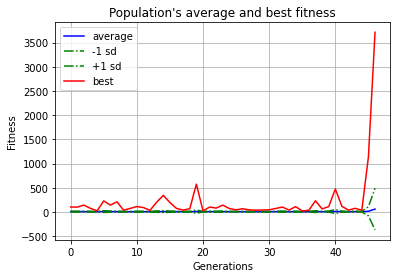

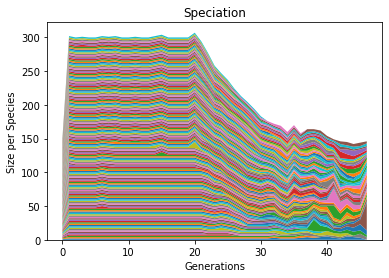

In [7]:
"""
Ai Pong Trainer using NEAT learning algorithm.

@author: John Trager

2020
"""
import gzip
import sys
import os
import pickle
from random import randint
from pygame import QUIT, init
import pygame
import neat
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import numpy as np

WIDTH = 480
HEIGHT = 360
GEN = 0
WIN_ON = True

init()
STAT_FONT = pygame.font.SysFont("comicsans", 40)
screen = pygame.display.set_mode((WIDTH,HEIGHT))
pygame.display.set_caption("Genetic Pong")

class Paddle:
    """
    Paddle Object
    """

    def __init__(self, x_c, y_c, color):
        """
        Initialize the object
        :param x_c: starting x_c pos (int)
        :param y_c: starting y_c pos (int)
        :return: Void
        """
        self.x_c = x_c
        self.y_c = y_c
        self.vel = 0
        self.color = color
        self.width = 5
        self.height = HEIGHT/10
        self.rect = pygame.Rect(self.x_c,self.y_c,self.width,self.height)

    def move_up(self):
        """
        make the object go up
        :return: Void
        """
        self.vel = -5

    def move_down(self):
        """
        make the object go down
        :return: Void
        """
        self.vel = 5

    def move_stop(self):
        """
        makes the object stop moving
        :return: Void
        """
        self.vel = 0

    def move(self):
        """
        moves paddle if not colliding with top or bottom of screen
        """
        if self.rect.top <= 0 and self.vel < 0:
            self.vel = 0
        elif self.rect.bottom >= HEIGHT and self.vel > 0:
            self.vel = 0

        self.rect = self.rect.move([0,self.vel])

    def draw(self, screen):
        """
        draws the pygram rects ontp the screen
        """
        pygame.draw.rect(screen, self.color, self.rect)

    def get_y(self):
        """
        returns the Y coordinate of the paddle
        """
        return self.rect.y

    def get_x(self):
        """
        returns the X coordinate of the paddle
        """
        return self.rect.x

class Ball:
    """
    Ball Object
    """

    def __init__(self, x_c, y_c, color):
        """
        Initialize the object
        :param x_c: starting x_c pos (int)
        :param y_c: starting y_c pos (int)
        :return: Void
        """
        self.x_c = x_c
        self.y_c = y_c
        self.vel = [random_sign()*4,random_sign()*4]
        self.color = color
        self.width = 10
        self.rect = pygame.Rect(self.x_c,self.y_c,self.width,self.width)

    def change_vel_y(self):
        """
        changes the objects y_c direction
        :return: Void
        """
        self.vel[1] = -self.vel[1]

    def change_vel_x(self):
        """
        changes the objects x_c direction
        :return: Void
        """
        self.vel[0] = -self.vel[0]

    def move(self):
        """
        moves ball object (with collision)
        """
        #if ball hits the bottom or top of screen change y_c direction
        if self.rect.top <= 0 or self.rect.bottom >= HEIGHT:
            self.change_vel_y()
        self.rect = self.rect.move([self.vel[0],self.vel[1]])

    def draw(self, screen):
        """
        Draws the rect object onto screen
        """
        pygame.draw.rect(screen, self.color, self.rect)

    def get_x(self):
        """
        returns Ball object X coordinate
        """
        return self.rect.x

    def get_y(self):
        """
        returns Ball object Y coordinate
        """
        return self.rect.y

    def collide(self, paddle):
        """
        Returns true if any portion of either rectangle overlap
        (except the top+bottom or left+right edges).
        """
        return self.rect.colliderect(paddle)

def draw_window(screen, paddles, paddles_r, balls):
    """
    draws the windows for the main game loop
    :param screen: pygame window surface
    :param paddles: a list of Left Paddles
    :param balls: a list of balls
    :return: None
    """
    #draws black screen
    screen.fill((0,0,0))

    #draws balls
    for ball in balls:
        ball.draw(screen)

    #draws left side paddles
    for paddle in paddles:
        paddle.draw(screen)

    #draws right side paddles
    for paddle in paddles_r:
        paddle.draw(screen)

    # generations
    score_label = STAT_FONT.render("Gens: " + str(GEN-1),1,(255,255,255))
    screen.blit(score_label, (10, 10))

    pygame.display.flip()

    screen_img = pygame.surfarray.array3d(screen)
    screen_img = np.rot90(screen_img)
    screen_img = np.flipud(screen_img)
    
    return screen_img



def save_object(obj, filename):
    """
    saves model into .pkl file
    """
    with gzip.open(filename, 'w', compresslevel=5) as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    """
    reads model from .pkl file and returns object
    TODO: as of 7-14-20 this function has had some problems that need to be sorted
    """
    with gzip.open(filename) as f:
        obj = pickle.load(f)
        return obj

def random_sign():
    """
    returns a random sign either -1 or +1
    """
    i = randint(0,1)
    if i == 0:
        return -1
    return 1

def eval_genomes(genomes, config):
    """
    evolves the different genomes using NEAT algorithm
    handles collisions and movement of paddles and balls
    """
    global GEN
    global WIN_ON
    GEN += 1
    score = 0

    paddles = []
    paddles_r = []
    balls = []
    nets = [] #holds all the differnet NN
    ge = [] # keeps track of genomes

    #for every genome set up a ball, paddle, and NN for it and put in ge to keep track
    for genome_id, g in genomes:
        tmp_color = (randint(100,255),randint(100,255),randint(100,255))
        net = neat.nn.FeedForwardNetwork.create(g,config)
        nets.append(net)
        paddles.append(Paddle(0,240,tmp_color))
        paddles_r.append(Paddle(WIDTH-5,240,tmp_color))
        balls.append(Ball(randint(100,255),randint(100,255),tmp_color))
        g.fitness = 0
        ge.append(g)

    clock = pygame.time.Clock()

    run = True
    while run and len(paddles) > 0:
        if WIN_ON: clock.tick(30)
        for event in pygame.event.get():
            if event.type == QUIT:
                run = False
                sys.exit()
                break
        #left paddle
        for x_c, paddle in enumerate(paddles):
            #given fitness for being alive
            ge[x_c].fitness += 0.05
            paddle.move()

            # send the inputs to the NNs and receive output and
            # decide if move up, down, or not move
            # todo: test out different inputs to the ANN,
            # try abs(paddle.y_c-ball.y_c) instead of ball.y_c or other variantions
            outputs = nets[paddles.index(paddle)].activate((paddle.get_y(),
                                    abs(paddle.get_x() - balls[paddles.index(paddle)].rect.x),
                                    balls[paddles.index(paddle)].rect.y))

            if outputs[0] > outputs[1]:
                if outputs[0] > 0.5:
                    paddle.move_up()
                else:
                    paddle.move_stop()
            elif outputs[1] > 0.5:
                paddle.move_down()
            else:
                paddle.move_stop()
        #right paddle
        for x_c, paddle in enumerate(paddles_r):
            #given fitness for being alive
            ge[x_c].fitness += 0.05
            paddle.move()

            outputs = nets[paddles_r.index(paddle)].activate((paddle.get_y(),
                            abs(paddle.get_x() - balls[paddles_r.index(paddle)].rect.x),
                            balls[paddles_r.index(paddle)].rect.y))

            if outputs[0] > outputs[1]:
                if outputs[0] > 0.5:
                    paddle.move_up()
                else:
                    paddle.move_stop()
            elif outputs[1] > 0.5:
                paddle.move_down()
            else:
                paddle.move_stop()

        #gives fitness to evolution if its corresponding ball
        for ball in balls:
            if ball.collide(paddles[balls.index(ball)]):
                ball.change_vel_x()
                ge[balls.index(ball)].fitness += 5
                score += 1
            if ball.collide(paddles_r[balls.index(ball)]):
                ball.change_vel_x()
                ge[balls.index(ball)].fitness += 5
                score += 1
            ball.move()
            if ball.get_x() < 0 or ball.get_x() > WIDTH:
                #check if paddle misses ball
                ge[balls.index(ball)].fitness -= 2
                nets.pop(balls.index(ball))
                ge.pop(balls.index(ball))
                paddles.pop(balls.index(ball))
                paddles_r.pop(balls.index(ball))
                balls.pop(balls.index(ball))

        #render / update screen
        if WIN_ON:
            screen_image = draw_window(screen, paddles, paddles_r, balls)

            '''
            plt.clf()
            plt.imshow(screen_image)
            plt.show()
            
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            '''

            screen_image = Image.fromarray(screen_image, 'RGB')
            display.display(screen_image)
            display.clear_output(wait=True)
            
            
           

            
    
  

        #breaks the evolution if the score reaches 500
        if score > 500:
          #pygame.time.wait(5)
          break
        
          
        
          
def run(config_file, model_name):
    """
    runs the NEAT algorithm to train a neural network to play pong.
    :param config_file: location of config file
    :return: Void
    """
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    #Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    #checkpoint = nexat.Checkpointer(5, "test")
    #p.add_reporter(neat.Checkpointer(5))

    # Run for up to 50 generations.
    winner = p.run(eval_genomes, 1000)
    #checkpoint.save_checkpoint()

    #save_object(winner, f"winner{str(datetime.datetime.now().time()).split('.')[0]+'_'+
    # str(datetime.datetime.now().date())}.pkl")

    # show final stats
    print('\nBest genome:\n{!s}'.format(winner))

    
    print('save the network as {}'.format(model_name))
    save_object(winner, model_name)

    neat.visualize.draw_net(config, winner, True, filename= 'net.png')
    neat.visualize.plot_stats(stats, ylog=False, view=True)
    neat.visualize.plot_species(stats, view=True)

if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, 'config-feedforward.txt')
    model_name = 'winner.pkl'
    run(config_path, model_name)

# Plot the corrosponding Network structure

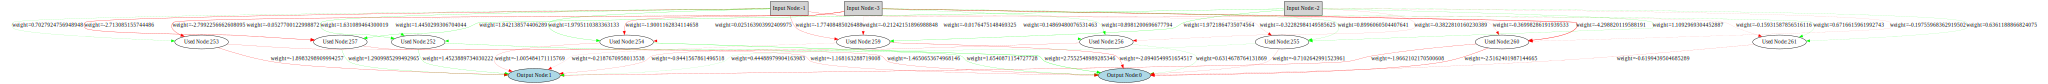

In [8]:
from IPython.display import SVG
SVG('net.png.svg')

# Test the Network

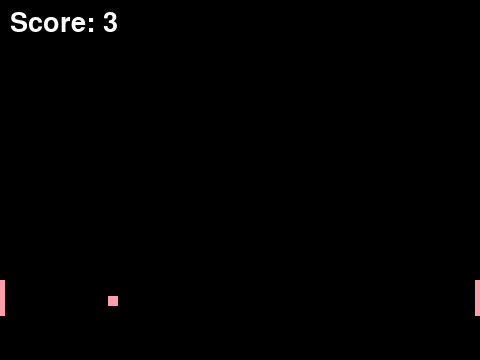

In [ ]:
 

def draw_test_window(screen, paddle, paddle_r, ball, score):
    """
    draws the windows for the main game loop
    :param screen: pygame window surface
    :param paddles: a list of Left Paddles
    :param balls: a list of balls
    :return: None
    """
    #draws black screen
    screen.fill((0,0,0))

    #draws balls
    ball.draw(screen)

    #draws left side paddles
    paddle.draw(screen)

    #draws right side paddles
    paddle_r.draw(screen)

    # score
    score_label = STAT_FONT.render("Score: " + str(score),1,(255,255,255))
    screen.blit(score_label, (10, 10))

    pygame.display.flip()

    screen_img = pygame.surfarray.array3d(screen)
    screen_img = np.rot90(screen_img)
    screen_img = np.flipud(screen_img)
    
    return screen_img

def test_network(net):

  #test the trained network    
  score = 0
  #fitness = 0
  clock = pygame.time.Clock()

  tmp_color = (randint(100,255),randint(100,255),randint(100,255))
  paddle_left = Paddle(0,240,tmp_color)
  paddle_right = Paddle(WIDTH-5,240,tmp_color)
  ball = Ball(randint(100,255),randint(100,255),tmp_color)
      

  run = True
  while run:
    clock.tick(30)
    for event in pygame.event.get():
        if event.type == QUIT:
            run = False
            sys.exit()
            break


    #left paddle and right paddle control
    paddle_left.move()
    paddle_right.move()
    
    #left paddle
    outputs_left = net.activate((paddle_left.get_y(),abs(paddle_left.get_x() - ball.rect.x), ball.rect.y))

    if outputs_left[0] > outputs_left[1]:
      if outputs_left[0] > 0.5:
        paddle_left.move_up()
      else:
        paddle_left.move_stop()
    elif outputs_left[1] > 0.5:
      paddle_left.move_down()
    else:
      paddle_left.move_stop()

    #right paddle
    outputs_right = net.activate((paddle_right.get_y(),abs(paddle_right.get_x() - ball.rect.x), ball.rect.y))

    if outputs_right[0] > outputs_right[1]:
      if outputs_right[0] > 0.5:
        paddle_right.move_up()
      else:
        paddle_right.move_stop()
    elif outputs_right[1] > 0.5:
      paddle_right.move_down()
    else:
      paddle_right.move_stop()



    #ball control
    
    if ball.collide(paddle_left):
        ball.change_vel_x()
        score += 1
    if ball.collide(paddle_right):
        ball.change_vel_x()
        score += 1
    ball.move()
    

    #render / update screen
        
    screen_image = draw_test_window(screen, paddle_left, paddle_right, ball, score)

    '''
    plt.clf()
    plt.imshow(screen_image)
    plt.show()
    
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    '''

    screen_image = Image.fromarray(screen_image, 'RGB')
    display.display(screen_image)
    display.clear_output(wait=True)
    if score > 500:      
      break        
            
if __name__ == '__main__':
    
  local_dir = os.getcwd()
  config_path = os.path.join(local_dir, 'config-feedforward.txt')

  model_name = 'winner.pkl'
  winner = load_object(model_name)
  config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        config_path)

  winner_net = neat.nn.FeedForwardNetwork.create(winner, config) 
  test_network(winner_net)       